
#Transporte de estados, los Centros de Wannier.

Para una descripción más precisa del fenómeno de bombeo, realizamos un seguimiento de la evolución de los centros de Wannier en el tiempo.

Definimos a los centros de Wannier como **el valor medio de la posición de los estados llenos**.


In [ ]:
from pylab import *

In [ ]:
%%capture
!pip install pythtb --upgrade

In [ ]:
from pythtb import *

In [ ]:
    a2 = array([ 1/2,sqrt(3)/2]) #vectores de red
    a3 = array([-1/2,sqrt(3)/2])
    a1 = a2-a3

    A1 = 2*a2
    A2 = 2*a3

In [ ]:
π   = pi                                  #Definimos parámetros que emplearemos a lo largo de nuestro trabajo 
C   = 77      # cm^-1               acoplamiento                 
κ   = 0.19    # μm^-1                      
δn0 = 0.05e-3   #amplitudes de modulación   #Energía de sitio, varía conel parámetro theta (índice de refracción)
L   = 50      # μm                          Separación entre guías vecinas
A   = 2.2     # μm                              
ϵ   = 1.469e4 # cm^-1

θ = π 

t = -2.7 # eV
β = 3.37 # parámetro de gruneissen 
ϵ = 0.05 # 50 meV
u = 0.2  # la deformación máxima es del 20%
acc = 1.42 # distancia carbono carbono

def func_cext(θ):
    return t*exp(-β*( acc*(1+u*cos(θ))/acc - 1 ))

def func_cint(θ):
    return t*exp(-β*( acc*(1-u*cos(θ))/acc - 1 ))

def func_δE(θ):
    return ϵ*sin(θ)

γ = 1.0 # 0.1*(1J)

In [ ]:
def hexaModel(θ):
  lat = [ A1, A2]
  orb = [ array([1,-1])/3, array([-1,1])/3, 
            array([1,0])/3, array([-1,0])/3, 
            array([0,1])/3, array([0,-1])/3  ]

  my_model = tb_model(2, 2, lat, orb)
  my_model.set_hop(func_cint(θ), 0, 2, [ 0, 0])
  my_model.set_hop(func_cint(θ), 1, 3, [ 0, 0])
  my_model.set_hop(func_cint(θ), 2, 4, [ 0, 0])
  my_model.set_hop(func_cint(θ), 3, 5, [ 0, 0])
  my_model.set_hop(func_cint(θ), 4, 1, [ 0, 0])
  my_model.set_hop(func_cint(θ), 5, 0, [ 0, 0])
    
  my_model.set_hop(func_cext(θ), 0, 1, [ 1,-1])
  my_model.set_hop(func_cext(θ), 2, 3, [ 1, 0])
  my_model.set_hop(func_cext(θ), 4, 5, [ 0, 1])
    
  # set on-site energies and hoppings
  ϵ1 = 1e-3
  ϵ2 = 1e-4
  my_model.set_onsite([γ*func_δE(θ)   ,-γ*func_δE(θ),        #términos en la diagonal del hamiltoniano
                    -γ*func_δE(θ)-ϵ1, γ*func_δE(θ)+ϵ1,
                     γ*func_δE(θ)+ϵ2,-γ*func_δE(θ)-ϵ2])
  return my_model


In [ ]:
# Obtener eigenvalores del la red finita
# para todos los valores de θ
def ModeloHOTI(θ,L=3):
    my_model   = hexaModel(θ)
    cut_one = my_model.cut_piece(L,0,glue_edgs=False)
    cut_two = cut_one.cut_piece(L,1,glue_edgs=False)
    E,U    = cut_two.solve_all(eig_vectors=True)
    return E,U
#L    = 3
θ    = linspace(-π,π,1000)  # Intervalo de θ
DATA = list( map(ModeloHOTI,θ)) 

Datosθ = {}
for n in range(len(θ)):
  Datosθ[θ[n]] = {"E":DATA[n][0], "U":DATA[n][1]}

  #print(Datosθ)

In [ ]:
# L es el número de celdas unitarias
# es decir, la cadena tiene 6*L sitios
L=3; θspan=linspace(-π,π,1000)#linspace(0,1,200) 
# Operador posición                    
POS_X = matrix(kron(diag([1,2,3,2,3,4,3,4,5]),eye(6)))

LwanflowX = []

for θ in θspan: #valores por los que pasa t 

    sys = ModeloHOTI(θ) #H.solve_all(eig_vectors=True)

    indFillBand = sys[0]<0
    Lval = sys[0][indFillBand] #eigenvalores negativos
    Lvec = matrix(sys[1][indFillBand]).T #eigenvectores negativos

    LP = Lvec*Lvec.H
    LW = LP*POS_X*LP #multiplicación de matrices
    LWval,LWvec  = eig(LW) #eigenvalores
    indEigNoCero = abs(LWval)>1e-10
                  
    LwanflowX.append(sort(LWval[indEigNoCero]))
LwanflowX = array(LwanflowX)

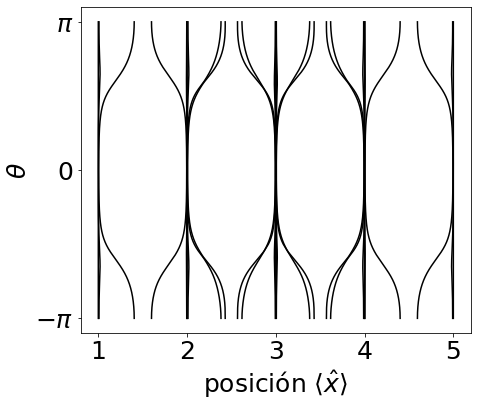

In [ ]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(7,6))
for n in range(27):
 plot(real(LwanflowX.T[n]) , θspan, color='k' )

ax.set_yticks([-pi,0,pi])
ax.set_yticklabels([r'$-\pi$',r'$0$',r'$\pi$'])
xlabel(r'posición $\langle \hat{x}\rangle$',fontsize=25);
ylabel(r'$\theta$',fontsize=25);
c=6
xticks(arange(1,c),fontsize=25)
yticks([-pi,0,pi],fontsize=25);
fig.savefig("WC66plot.png",dpi=300)

El resultado muestra que durante un ciclo completo, cada centro de Wannier se mueve de una celda a otra, de derecha a izquierda y viceversa.